# Lap-by-lap place cell processing
**Notebook to break the place cell data into laps to look at the onset of place cell activity.**

Import functions

In [171]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets

import pickle

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets


In [172]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

File input

In [173]:
data_dir = "../data/"
save_location = "../output_data/Exp002_psi/"


exp_sets = ['chrimsonR'] # ensure following datasets, session names and filenames are the same for all sets that need processing
data_sets = ['Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri']
#data_sets = ['Day7-8 - Hex-VehHex-Hex','Day3 - Hex-PsyHex-Hex', 'COMP360-Squ-Squ', 'Vehicle-Squ-Squ']
#data_sets = ['Day7-8- Tri-Tri-Tri', 'Day8-9 - Tri-VehTri-Tri', 'Day10-11 - Tri-PsiTri-Tri', 'Drug A - Tri-Nov1-Nov2', 'Drug B - Tri-Nov1-Nov2', 'Day18-19 - Tri-PsiTri-Tri', 'Day20-21 - Tri-PsiNov1-Nov2']


#data_titles = ['Familiar Time control', 'Familiar Vehicle Control', 'Familiar Psilocybin', 'Novel Vehicle', 'Novel Psilocybin 1mg/kg', 'Familiar Psilocybin 3mg/kg', 'Novel Psilocybin 3mg/kg']
#data_titles = ['Vehicle control','Psilocybin', 'Novel Psilocybin', 'Novel Vehicle']
#data_titles = ['Day6 - Familiar - OptoNovel - Novel', 'Day6-7 - OptoNovel - Novel2 - Novel3', 'Day6-7 All active - OptoNovel - Novel2 - Novel3']
data_titles = ['Day2 - Familiar -  Novel 1 - Novel 2', 'Day4 - Familiar - Familiar - Familiar']

#session_names = [["Familiar", "Familiar", "Familiar"], ["Familiar", "VehFamiliar", "Familiar"], ["Familiar", "PsiFamiliar", "Familiar"], ["Familiar", "A Novel 1", "Novel 2"], ["Familiar", "B Novel 1", "Novel 2"],["Familiar", "PsiFamiliar", "Familiar"], ["Familiar", "Psi Novel 1", "Novel 2"]]
#session_names = [["Familiar", "30 minutes", "60 minutes"],["Familiar", "30 minutes", "60 minutes"], ["Novel 1", "Novel 2"], ["Novel 1", "Novel2"]]
session_names = [["Familiar", "Novel", "Novel"], ["Familiar", "Familiar", "Familiar"]]

#data_filenames = ['ratemap_structure_day7-8', 'ratemap_structure_day8-9', 'ratemap_structure_day10-11', 'ratemap_structure_A', 'ratemap_structure_B', 'ratemap_structure_day18-19', 'ratemap_structure_day20-21']
#data_filenames = ['ratemap_structure_day1.mat','ratemap_structure_day3.mat', 'ratemap_structure_novel_comp360.mat', 'ratemap_structure_novel_vehicle']
data_filenames = ['ratemap_structure_day2', 'ratemap_structure_day4']

output_dir = "../output_figs/"

opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)
whole_track_bins = [6, 35]

In [174]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )



# create an instance of the data loader
#data = data_loader(data_dir, data_sets, data_filenames, data_titles, session_names)

# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri'), value='Day2 - Squ-T…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

**Main analysis including:**
1. Selecting pooled or specific animal data to process
2. Creating variables to hold placecell rates, all rates and spatial info
3. Sorting  ratemaps based on user input for display and calculations
4. Calculate average rate across spatial bins with SEM, and PV correlations (each bin vs same and all other bins)

In [175]:
# get widgets values and process data
animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value
sort_by_index = sort_by.index
compare_to_place = activity_type.index
plot_opto = show_opto.value

placecell_rates_dict = data.placecell_rates_dict
placecell_info_dict = data.placecell_info_dict
spikes_dict = data.spikes_dict
behaviour_dict = data.behaviour_dict

raw_rates_dict = data.raw_rates_dict
#raw_rates_info_dict = data.allcell_info_dict

sub_titles = data.sub_titles
data_set_to_plot = data.data_set_to_plot
title_for_data = data.title_for_data 
display_placecells = ratemap_type.index


# Select which data to be included in analysis
if animal_id == 'pooled data':
    #concatonate all of the animals ontop of eachother into a list
    placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)
    placecell_spatial_info = create_pooled_data(placecell_info_dict,ids_to_pool)
    raw_rates = create_pooled_data(raw_rates_dict,ids_to_pool)
    rates_average, rates_sem = get_pooled_average_rates(raw_rates_dict,ids_to_pool)
    coors_diags_mean, coors_diags_sem, opto_zone_diag, ctrl_zone_diag, fulltrack_diag, opto_zone_avg, control_zone_avg, fulltrack_avg = get_pooled_avg_corrs(raw_rates_dict,
                                                                                                                              placecell_rates_dict,
                                                                                                                              sort_by_index,
                                                                                                                              compare_to_place,
                                                                                                                              ids_to_pool,
                                                                                                                              opto_bins,
                                                                                                                              control_bins,
                                                                                                                              whole_track_bins)
else:
    placecell_rates = placecell_rates_dict[animal_id]
    raw_rates = raw_rates_dict[animal_id]
    rates_average = get_average_rates(raw_rates_dict,animal_id)


# sort the ratemaps based on the user input
compare_rates = placecell_rates[sort_by_index]
sort_id, sort_index = sort_ratemaps(compare_rates)

# using the indices of sort_id Sort each placecell and rawrates  DataFrames in the list of dataframes and s and convert 
place_rates_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_rates]
raw_rates_sorted = [df.reindex(sort_id).fillna(0) for df in raw_rates]
spatial_info_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_spatial_info]

#get the placefield center for sorted ratemaps
place_rates_sorted_centers = [get_placecell_centers(df) for df in place_rates_sorted]
raw_rates_sorted_centers = [get_placecell_centers(df) for df in raw_rates_sorted]


# Proccess which rate maps to display          
if compare_to_place:
    display_rates = place_rates_sorted
else:
    display_rates = raw_rates_sorted
    display_rates[sort_by_index] = place_rates_sorted[sort_by_index]

# create the arrays to used for correlation
array1 = display_rates[sort_by_index].values
array2 = [df.values for df in display_rates]

# create the population vector correlation
place_rates_popveccorr = [create_corr_matrix(array1,array2[i]) for i in range(len(array2))]

# create the spatial correlation
place_rates_spatialcorr = [spatial_corr(array1,array2[i]) for i in range(len(array2))]


if animal_id != 'pooled data':

    coors_diags_mean = [np.diagonal(corrs) for corrs in place_rates_popveccorr]
    opto_zone_avg = [[np.mean(corrs[opto_bins[0]:opto_bins[1]+1,opto_bins[0]:opto_bins[1]+1])] for corrs in place_rates_popveccorr]
    control_zone_avg = [[np.mean(corrs[control_bins[0]:control_bins[1]+1,control_bins[0]:control_bins[1]+1])] for corrs in place_rates_popveccorr]

    opto_zone_diag = [[np.nanmean(id[opto_bins[0]:opto_bins[1]+1])] for id in coors_diags_mean]
    ctrl_zone_diag = [[np.nanmean(id[control_bins[0]:control_bins[1]+1])] for id in coors_diags_mean]


if display_placecells:
    rates_to_plot =  sort_placecells(placecell_rates)
else:
    rates_to_plot = display_rates


/home/dipl0id/Documents/OLM_and_placecell_project/olm_venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/dipl0id/Documents/OLM_and_placecell_project/olm_venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


**Loop through all data and pull out the lap by lap rates**

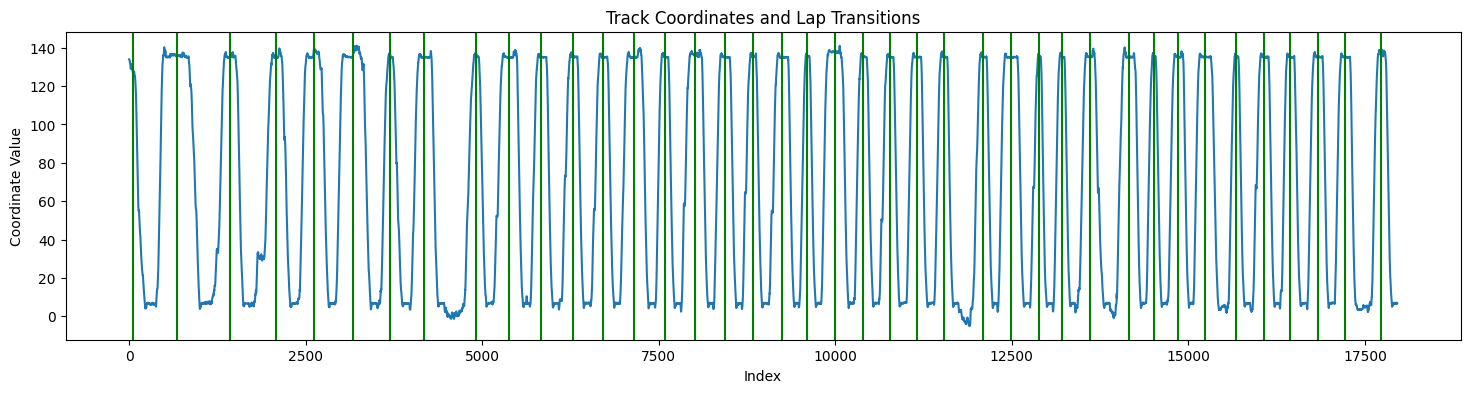

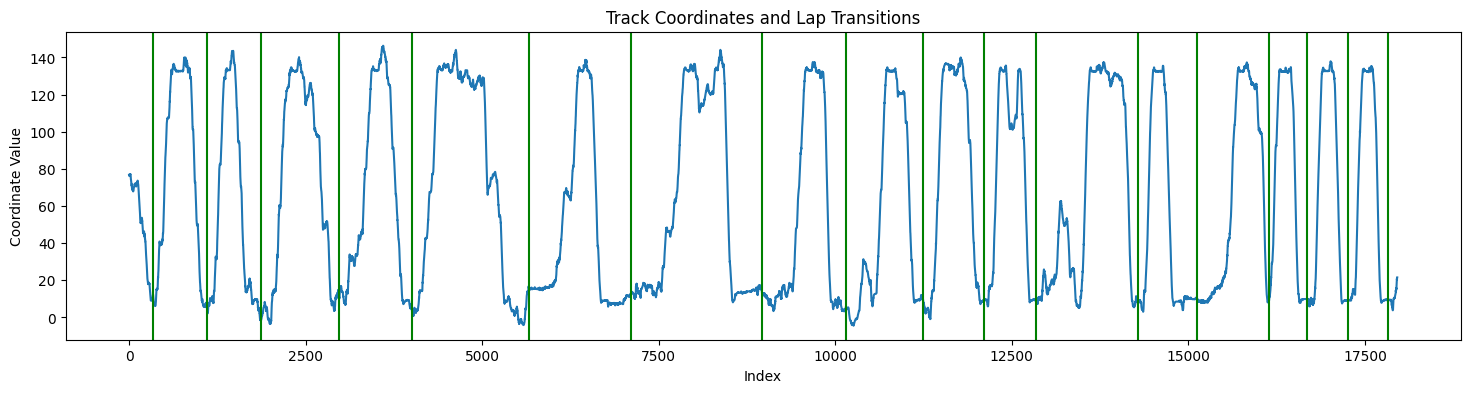

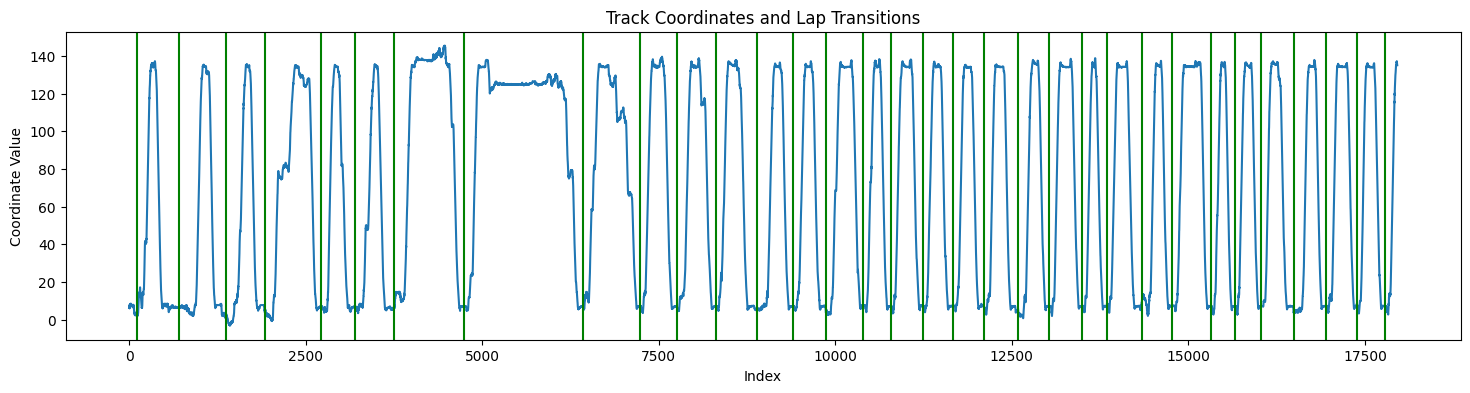

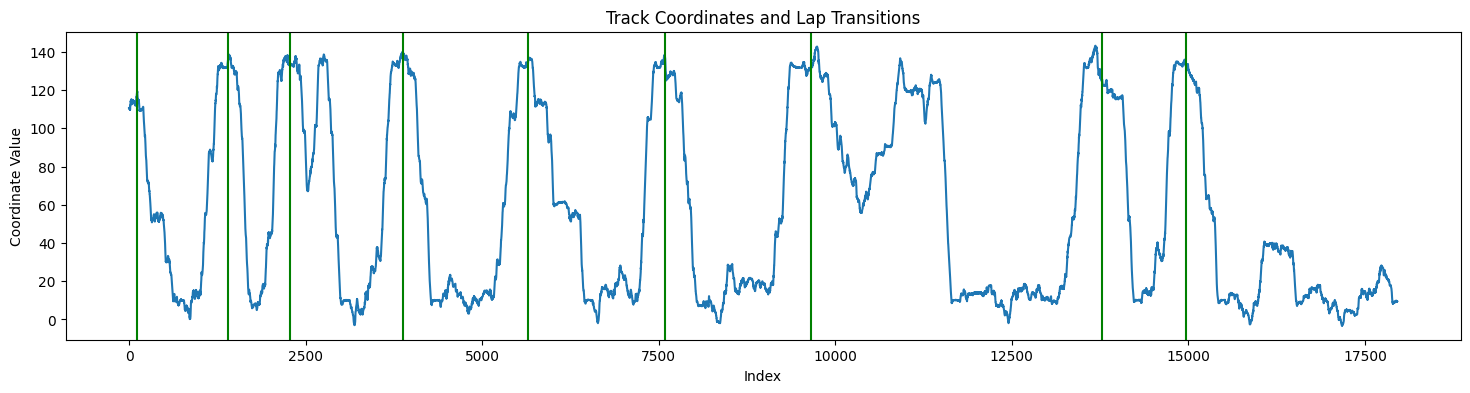

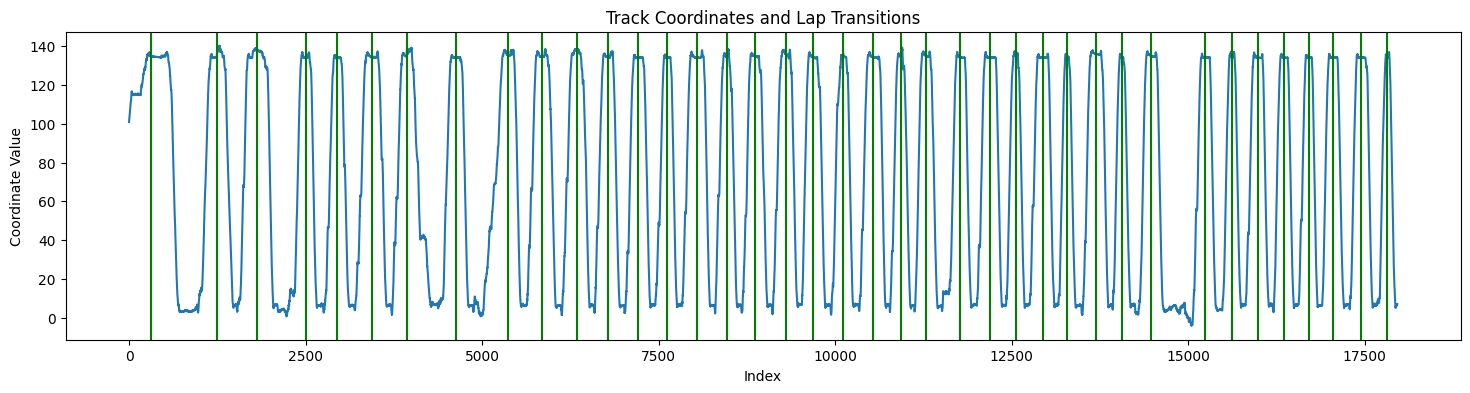

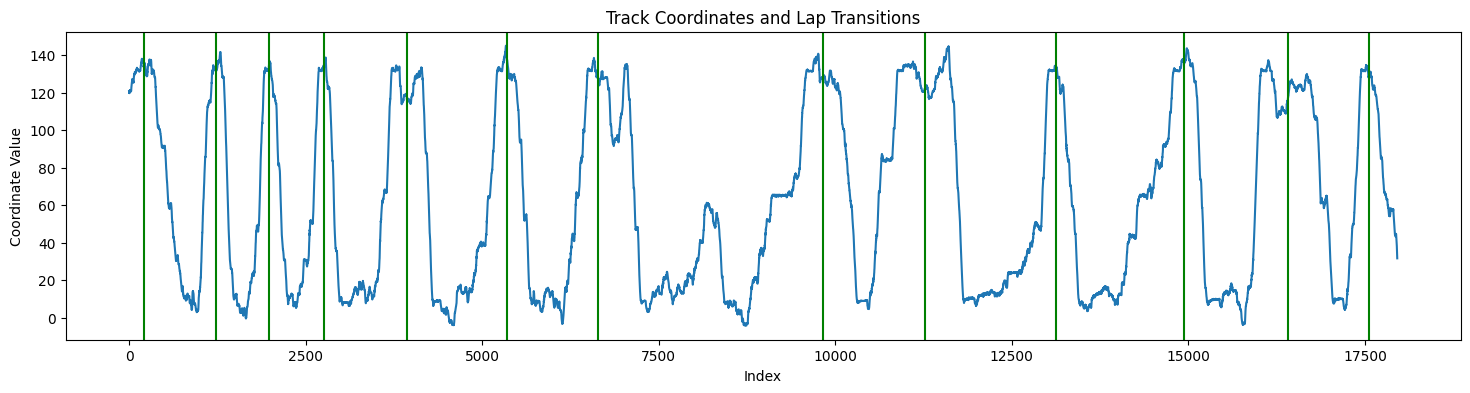

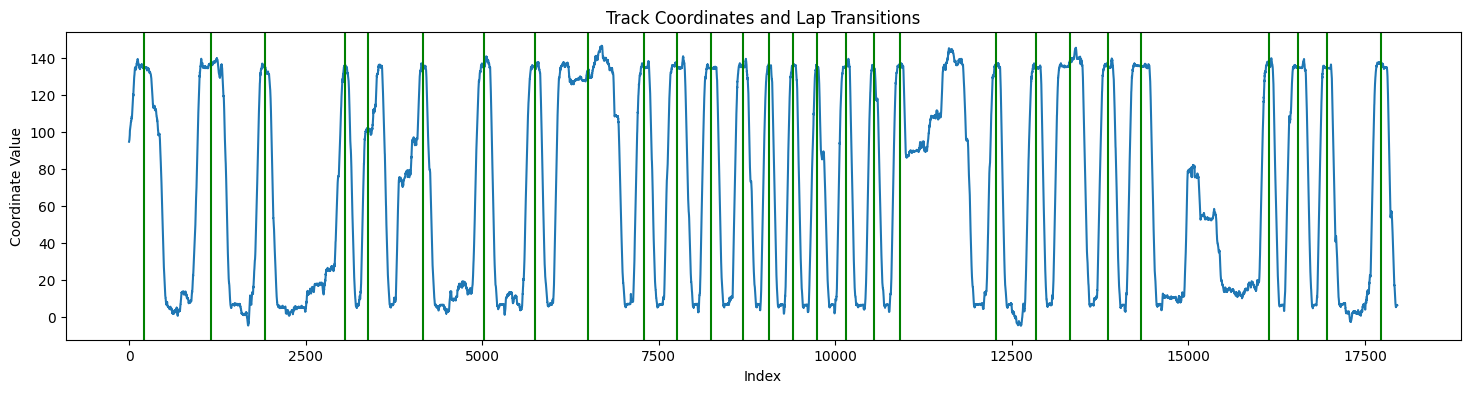

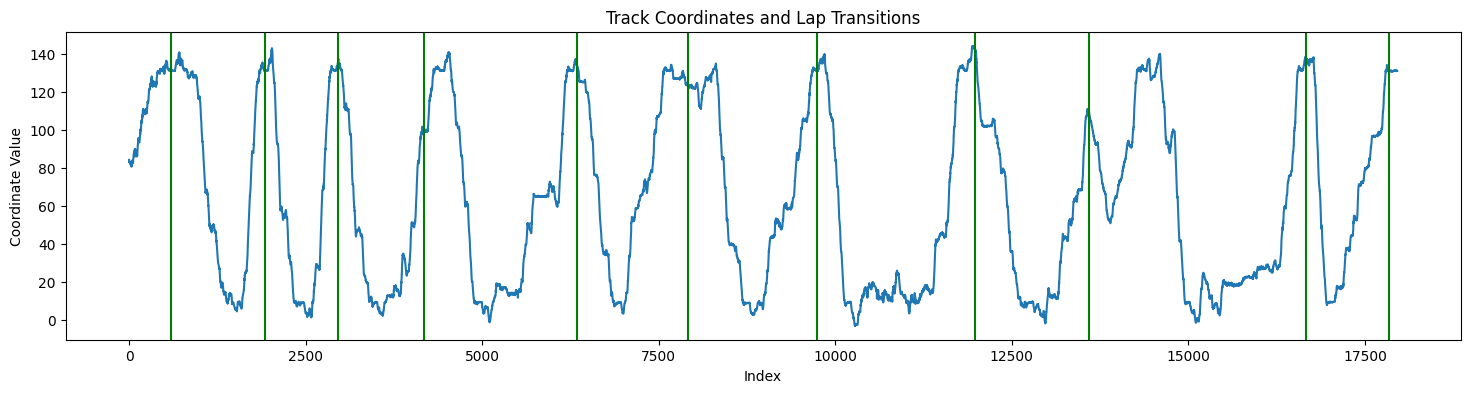

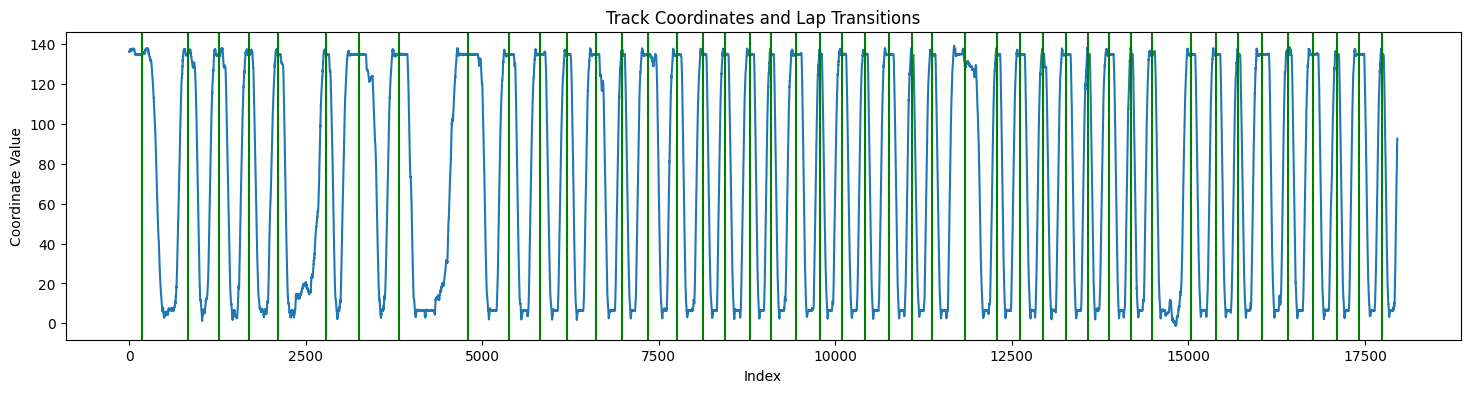

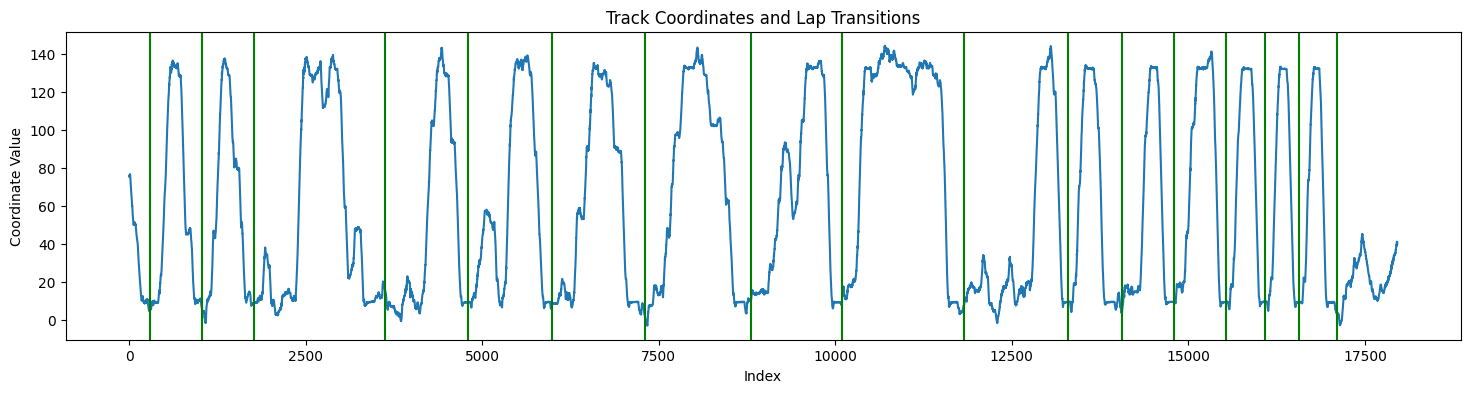

In [176]:
# loop for animals
lap_by_lap_array = {} 
for animal in data.animals:
    lap_by_lap_array[animal] = {}
    
    # loop for sessions
    sessions = [0, 1] 
    for session_index in sessions:

       
        # beh and spike data for current animal and session
        working_behav_dict = behaviour_dict[animal][session_index]
        working_spike_dict = spikes_dict[animal][session_index]

        # extract behaviour varuables needed
        x_coords = working_behav_dict['x_coord']
        #velocity = working_behav_dict['velocity']
        time = working_behav_dict['frame_time']
        right_runs = working_behav_dict['right_runs']
        left_runs = working_behav_dict['left_runs']
        
        # get the transition points between laps
        lap_transitions = get_laps_from_coords(
            x_coords, plot_output=True, output_half_laps=False, filter_size = 20
        )
        number_laps = len(lap_transitions)-1

        # get cells 
        cells = working_spike_dict.columns.tolist()
        number_cells = len(cells) 
        number_bins = 40 

        # initialise 4D array: (cells, bins, laps, directions) and sessions within lap_by_lap_array
        session_array = np.zeros((number_cells, number_bins, number_laps, 2)) # directions 2 for left/right 
        lap_by_lap_array[animal][session_index] = session_array

        # initialise dictionary to add each cells lap rates
        rates_per_lap_dict = {}
        
        # iterate through each of the cells
        for cell_index, cell in enumerate(cells):
            cell_spiketime = working_spike_dict[cell].values

            # drop the nans from the array
            cell_spiketime = cell_spiketime[~np.isnan(cell_spiketime)]

            # create some empty lists to populate later
            # right_lap_rates_smooth = []
            # right_lap_rates_smooth_norm = []
            # right_lap_rates = []
            # left_lap_rates_smooth = []
            # left_lap_rates_smooth_norm = []
            # left_lap_rates = []

            # loop through laps
            for lap_index in range(number_laps):

                lap_bounds = np.arange(lap_transitions[lap_index], lap_transitions[lap_index+1])
                lap_times = time[lap_bounds]
                lap_coords= x_coords[lap_bounds]
                lap_right_runs = ~np.isnan(right_runs[lap_bounds])
                lap_left_runs = ~np.isnan(left_runs[lap_bounds])
                #lap_velocity = velocity[lap_bounds]

                # Filter spikes for the lap 
                inlap = cell_spiketime[
                    (cell_spiketime > lap_times[0]) & (cell_spiketime < lap_times[-1])
                ]

                reward_edges = [16, 125]
                #velocity_threshold = 7
                full_track_length = 141
                reward_length = 16

                # calculate the bin edges for the ratemaps
                bin_edges = np.linspace(reward_length, full_track_length-reward_length, number_bins+1)

                # loop for if spikes present for cell in lap 
                if len(inlap) > 0:

                    # find the index of the lap time that is closest to the spike time
                    spike_ind = [int(abs(lap_times - t).argmin()) for t in inlap]
                    spike_ind = np.array(spike_ind)

                    # masks for velocity and track bounds and left right runs
                    #vel_mask = lap_velocity[spike_ind]> velocity_threshold # not sure if actually need vel mask as right and left runs are already filtered for velocity in matlab 
                    track_mask  = (lap_coords[spike_ind]> reward_edges[0]) & (lap_coords[spike_ind]< reward_edges[1])
                    
                    # Right laps (restructured but same code)
                    right_run_mask = lap_right_runs[spike_ind]
                    spike_coords_right = lap_coords[
                        spike_ind[np.logical_and.reduce((track_mask, right_run_mask))] # can do (vel_mask, track_mask, right_run_mask) if using velocity variable
                    ]
                    events_per_bin_right, _ = np.histogram(spike_coords_right, bins=bin_edges)
                    session_array[cell_index, :, lap_index, 0] = events_per_bin_right # currently no smoothing but can add in 

                    # Left laps (restructured as above)
                    left_run_mask = lap_left_runs[spike_ind]
                    spike_coords_left = lap_coords[
                        spike_ind[np.logical_and.reduce((track_mask, left_run_mask))] # can do (vel_mask, track_mask, right_run_mask) if using velocity variable
                    ]
                    events_per_bin_left, _ = np.histogram(spike_coords_left,bins=bin_edges)
                    session_array[cell_index, :, lap_index, 1] = events_per_bin_left # currently no smoothing but can add in 

        # Store the session's 4D array
        #lap_by_lap_array[animal][session_index] = session_array
        lap_by_lap_array[animal][session_index] = {
            "data": session_array,
            "cell_ids": cells  # this is your list of cell IDs already defined above
        }


Check that a single cell from an animal and session can be extracted 

In [121]:
animal = 'mu33'
session = 1
cell_index = 1  # or whatever index you want

# Access the session data
session_data = lap_by_lap_array[animal][session]

# Get the full 4D data array and cell IDs
data = session_data["data"]        # shape: (n_cells, n_bins, n_laps, 2)
cell_ids = session_data["cell_ids"]

# Get the actual cell ID
cell_id = cell_ids[cell_index]

# Get this cell’s data
cell_array = data[cell_index]      # shape: (n_bins, n_laps, 2)


Generating matrices for plotting 

In [122]:
example_animal = 'mu33'
example_session_index = 1

# Pull out the correct session dictionary
example_session = lap_by_lap_array[example_animal][example_session_index]

# Access the 4D array from the dictionary
session_data = example_session["data"]

# Split directions
right_laps_data = session_data[:, :, :, 0]
left_laps_data = session_data[:, :, :, 1]

# Reshape
number_cells, number_bins, number_laps = right_laps_data.shape
right_laps_matrix = right_laps_data.reshape(number_cells * number_bins, number_laps)

number_cells, number_bins, number_laps = left_laps_data.shape
left_laps_matrix = left_laps_data.reshape(number_cells * number_bins, number_laps)

# Print shape
print(f"Right laps matrix shape: {right_laps_matrix.shape}")
print(f"Left laps matrix shape: {left_laps_matrix.shape}")

# Check non-zero values
non_zero_exists_r = np.any(right_laps_matrix)
non_zero_exists_l = np.any(left_laps_matrix)

non_zero_count_r = np.count_nonzero(right_laps_matrix)
non_zero_count_l = np.count_nonzero(left_laps_matrix)

if non_zero_exists_r:
    print(f"The right laps matrix contains {non_zero_count_r} non-zero values.")
else:
    print("The right laps matrix is entirely zeros.")

if non_zero_exists_l:
    print(f"The left laps matrix contains {non_zero_count_l} non-zero values.")
else:
    print("The left laps matrix is entirely zeros.")



Right laps matrix shape: (31680, 31)
Left laps matrix shape: (31680, 31)
The right laps matrix contains 2711 non-zero values.
The left laps matrix contains 3195 non-zero values.


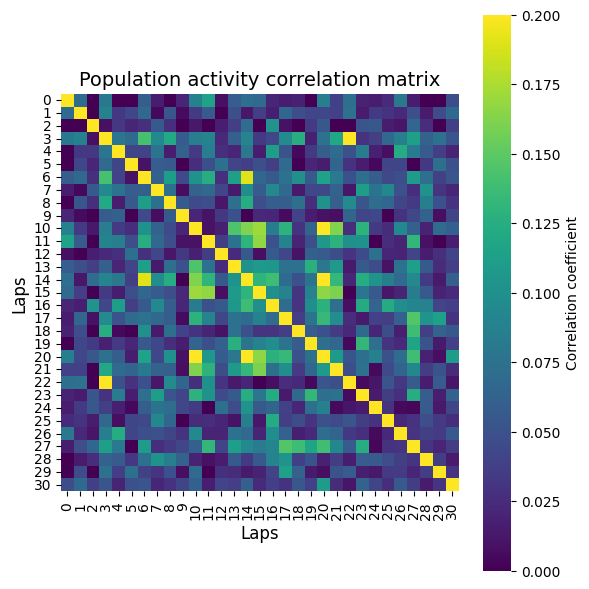

In [177]:
# Normalisation function 
def normalise_heatmap(a,axisindex):
    b=a
    for c in range(0,a.shape[axisindex]):
        norm2=np.nansum(a[:,c]**2)
        if norm2!=0:
            b[:,c]=a[:,c]/np.sqrt(norm2) 
    return b

#a_total = right_laps_matrix
a_total = left_laps_matrix

# Normalise heatmap: need to define function from Charline's code 
a_total = normalise_heatmap(a_total, 1)

plt.close("all")  # Close all previous plots
fig, ax = plt.subplots(figsize=(6, 6))  # Create a new figure

# Axes labels
ax.set_ylabel("Trials")
ax.set_xlabel("Trials")

# Setting axis limits
(ymin, ymax) = ax.set_ylim(-0.5,number_laps)
(xmin, xmax) = ax.set_xlim(-0.5, number_laps)

# Replace NaN values with zero
a_total[np.isnan(a_total)] = 0  

## Don't think we need trial range section or odering trials 

# trials_before = range(0, behav['before']["number_trials"])
# trials_after_new = np.zeros(number_laps)
# trials_last_new = np.zeros(number_laps)

# if trials_order_lick_rate:  
#     a_new = 0 * a_total
#     count = 0
#     sw_plot = []
#     for clus in idx_per_cluster:
#         a_new[:, count:count + len(clus)] = a_total[:, clus]
#         sw_plot.append(count)
#         countclus = 0
#         for idxclus in clus:
#             if idxclus[0] > behav['before']["number_trials"]:
#                 trials_after_new[count + countclus] = 1
#             if numberswitch > 1:
#                 if idxclus[0] > behav['after']["number_trials"] + behav['before']["number_trials"]:
#                     trials_last_new[count + countclus] = 1
#                     trials_after_new[count + countclus] = 0
#             countclus += 1
#         count += len(clus)
#     sw_plot = sw_plot[1:]
# else:
#     a_new = a_total

a_new = a_total

# Compute cosine similarity matrix
# cosine_mat = np.matmul(a_new.transpose(), a_new)
cosine_mat = np.corrcoef(a_new.T)
lap_indices = np.arange(a_new.shape[1])

# Plot the cosine matrix
# plt.pcolormesh(range(0, number_laps), range(0, number_laps), cosine_mat, vmin=0, vmax=1)


# Create a Seaborn heatmap
sns.heatmap(
    cosine_mat,
    cmap='viridis',        # Color map for the heatmap
    vmin=0, vmax=0.2,         # Set value range for the color bar
    cbar=True,              # Enable the color bar
    square=True,            # Make cells square
    xticklabels=lap_indices,      # Disable x-tick labels
    yticklabels=lap_indices,      # Disable y-tick labels
    cbar_kws={"label": "Correlation coefficient"}  # Label for the color bar
)

# Add plot title and labels
ax.set_title("Population activity correlation matrix", fontsize=14)
ax.set_xlabel("Laps", fontsize=12)
ax.set_ylabel("Laps", fontsize=12)

# Tight layout to fit elements
plt.tight_layout()
plt.show()

## Don't think I need this bit of code either as for switches 

# Mark switches in the plot
# for s in sw_plot:
#     ax.arrow(s - 0.5, ymin - 0.5, 0, ymax + abs(ymin) + 0.5, color="m", linewidth=0.5, label="Switch reward contingency")
#     ax.arrow(xmin - 0.5, s - 0.5, xmax + abs(xmin) + 0.5, 0, color="m", linewidth=0.5, label="Switch reward contingency")

# # Mark trial phases
# count = 0
# if numberswitch > 0:
#     for i in range(0, total_number_trials):
#         if trials_after_new[i] != 0:
#             ax.arrow(0, i - 0.5, 0, 1, color="orange", linewidth=4, label="Trials after", head_width=0)
#             ax.arrow(i - 0.5, 0, 1, 0, color="orange", linewidth=4, label="Trials after", head_width=0)
#             count += 1
#         if trials_last_new[i] != 0:
#             ax.arrow(0, i - 0.5, 0, 1, color="red", linewidth=4, label="Trials last", head_width=0)
#             ax.arrow(i - 0.5, 0, 1, 0, color="red", linewidth=4, label="Trials last", head_width=0)
#             count += 1


In [178]:
example_animal = 'mu33'
example_session_index = 1

# Pull out the correct session dictionary
example_session = lap_by_lap_array[example_animal][example_session_index]

# Access the 4D array and cell IDs from the dictionary
session_data = example_session["data"]           # shape: (cells, bins, laps, directions)
session_cell_ids = example_session["cell_ids"]   # list of all cell IDs in the session

# Get the place cell DataFrame for this animal and session
place_cells_df = placecell_info_dict[example_animal][example_session_index]

# Extract place cell IDs as a list
place_cell_ids = place_cells_df.index.to_list()

# Find indices of these place cells in session_cell_ids
place_cell_indices = [session_cell_ids.index(pc) for pc in place_cell_ids if pc in session_cell_ids]

# Extract data only for place cells
place_cells_data = session_data[place_cell_indices, :, :, :]  # subset along first dimension (cells)

# Split directions for place cells
right_laps_place_data = place_cells_data[:, :, :, 0]
left_laps_place_data = place_cells_data[:, :, :, 1]

# Reshape for easier lap-by-lap analysis
num_place_cells, number_bins, number_laps = right_laps_place_data.shape
right_laps_place_matrix = right_laps_place_data.reshape(num_place_cells * number_bins, number_laps)

num_place_cells, number_bins, number_laps = left_laps_place_data.shape
left_laps_place_matrix = left_laps_place_data.reshape(num_place_cells * number_bins, number_laps)

# Print shapes and stats
print(f"Right laps place matrix shape: {right_laps_place_matrix.shape}")
print(f"Left laps place matrix shape: {left_laps_place_matrix.shape}")

non_zero_count_r = np.count_nonzero(right_laps_place_matrix)
non_zero_count_l = np.count_nonzero(left_laps_place_matrix)

print(f"The right laps place matrix contains {non_zero_count_r} non-zero values.")
print(f"The left laps place matrix contains {non_zero_count_l} non-zero values.")


Right laps place matrix shape: (7960, 16)
Left laps place matrix shape: (7960, 16)
The right laps place matrix contains 1396 non-zero values.
The left laps place matrix contains 1502 non-zero values.


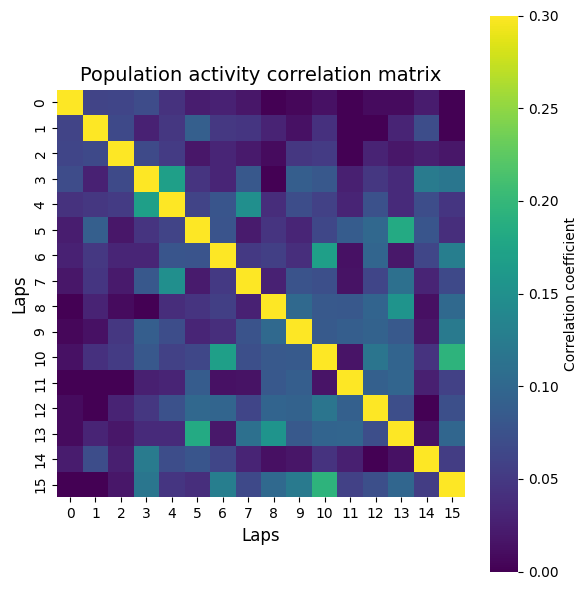

In [179]:
#a_total = left_laps_place_matrix
a_total = right_laps_place_matrix

# Normalise heatmap: need to define function from Charline's code 
a_total = normalise_heatmap(a_total, 1)

plt.close("all")  # Close all previous plots
fig, ax = plt.subplots(figsize=(6, 6))  # Create a new figure

# Axes labels
ax.set_ylabel("Trials")
ax.set_xlabel("Trials")

# Setting axis limits
(ymin, ymax) = ax.set_ylim(-0.5,number_laps)
(xmin, xmax) = ax.set_xlim(-0.5, number_laps)

# Replace NaN values with zero
a_total[np.isnan(a_total)] = 0  

a_new = a_total

# Compute cosine similarity matrix
cosine_mat = np.matmul(a_new.transpose(), a_new)
# correlation_mat = np.corrcoef(a_new.T)
lap_indices = np.arange(a_new.shape[1])

# Plot the cosine matrix
# plt.pcolormesh(range(0, number_laps), range(0, number_laps), cosine_mat, vmin=0, vmax=1)


# Create a Seaborn heatmap
sns.heatmap(
    cosine_mat,
    cmap='viridis',        # Color map for the heatmap
    vmin=0, vmax=0.3,         # Set value range for the color bar
    cbar=True,              # Enable the color bar
    square=True,            # Make cells square
    xticklabels=lap_indices,      # Disable x-tick labels
    yticklabels=lap_indices,      # Disable y-tick labels
    cbar_kws={"label": "Correlation coefficient"}  # Label for the color bar
)

# Add plot title and labels
ax.set_title("Population activity correlation matrix", fontsize=14)
ax.set_xlabel("Laps", fontsize=12)
ax.set_ylabel("Laps", fontsize=12)

# Tight layout to fit elements
plt.tight_layout()
plt.show()

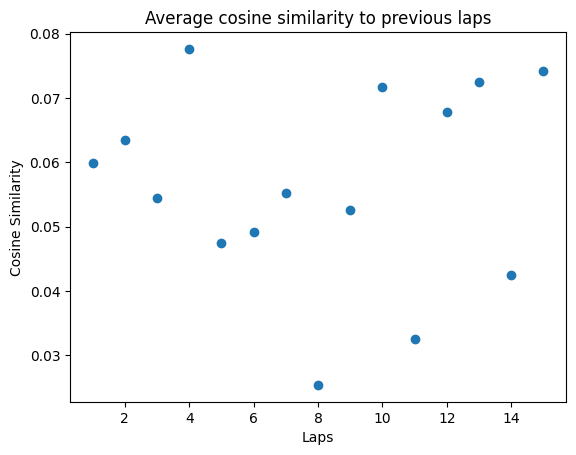

In [180]:
# Average similarity of lap to all previous laps
avg_cos_sim_prev = []
for i in range(1, len(cosine_mat[0,:])):
    # Do not include similarity with self
    avg_cos_sim_prev.append(np.mean(cosine_mat[0:i, i]))
avg_cos_sim_prev = np.asarray(avg_cos_sim_prev)
avg_cos_sim_prev[np.isnan(avg_cos_sim_prev)] = 0.0
plt.close("all")
plt.scatter(range(1, len(cosine_mat[0,:])), avg_cos_sim_prev)
plt.xlabel("Laps")
plt.ylabel("Cosine Similarity")
plt.title("Average cosine similarity to previous laps")
plt.show()


[0.06717394 0.06442656 0.06450959 0.06482838 0.06058255 0.0656396
 0.05086819 0.0598403  0.04785938 0.0309794  0.03741928 0.04543219
 0.03187517 0.01123666 0.        ]


<>:12: SyntaxWarning: invalid escape sequence '\i'
<>:12: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_81898/2308605005.py:12: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Average cosine similarity between laps " + '$\it{k}$' + " apart")


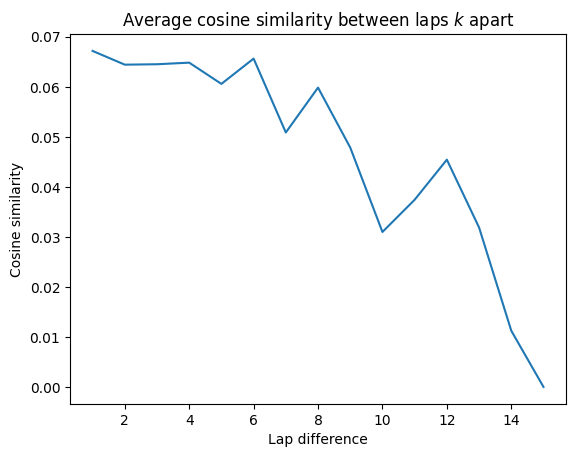

In [181]:
# Decay curve as a function of lap difference k (e.g. where k = 3, compute the mean similarity between all laps three apart)
max_lap_diff = len(cosine_mat[0,:])
lap_diff_avg = []
idx_x, idx_y = np.indices(cosine_mat.shape)
for i in range(1, max_lap_diff):
    lap_diff_avg.append(np.mean(cosine_mat[np.abs(idx_x - idx_y) == i]))
lap_diff_avg = np.asarray(lap_diff_avg)
plt.close("all")
plt.plot(range(1, max_lap_diff), lap_diff_avg)
plt.xlabel("Lap difference")
plt.ylabel("Cosine similarity")
plt.title("Average cosine similarity between laps " + '$\it{k}$' + " apart")
print(lap_diff_avg)